# Create Expanded Synthetic Choke Dataset (100 points)
Generate a larger, more realistic synthetic dataset to properly test the differences between baseline and sweet spot models.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Load original training data to understand realistic ranges
training_data = pd.read_parquet('training_data/wide36_tools_flat.parquet')
IF_CHOKE_FEATS = ["Choke-Position", "ToolStateNum", "Downstream-Temperature"]

print("Training data statistics for reference:")
display(training_data[IF_CHOKE_FEATS].describe())

Training data statistics for reference:


param,Choke-Position,ToolStateNum,Downstream-Temperature
count,1.288266e+06,1.288266e+06,1.288266e+06
mean,6.754809e+01,2.899904e+00,2.353058e+01
std,4.711706e+01,7.115145e+00,2.289152e+01
min,-1.891891e+00,0.000000e+00,7.410614e+00
25%,-3.243103e-01,2.000000e+00,1.496844e+01
50%,1.006216e+02,2.000000e+00,1.582581e+01
75%,1.008378e+02,5.000000e+00,1.711368e+01
max,1.028649e+02,7.680000e+03,1.082159e+02


In [2]:
# Analyze the actual distributions to create realistic synthetic data
print("=== DETAILED STATISTICS FOR REALISTIC SYNTHESIS ===")
for col in IF_CHOKE_FEATS:
    data = training_data[col]
    print(f"\n{col}:")
    print(f"  Range: {data.min():.3f} to {data.max():.3f}")
    print(f"  Mean±Std: {data.mean():.3f} ± {data.std():.3f}")
    print(f"  Median: {data.median():.3f}")
    print(f"  IQR: {data.quantile(0.25):.3f} to {data.quantile(0.75):.3f}")
    print(f"  99th percentile: {data.quantile(0.99):.3f}")
    print(f"  1st percentile: {data.quantile(0.01):.3f}")
    
    if col == "ToolStateNum":
        print(f"  Most common values: {data.value_counts().head(5).to_dict()}")

=== DETAILED STATISTICS FOR REALISTIC SYNTHESIS ===

Choke-Position:
  Range: -1.892 to 102.865
  Mean±Std: 67.548 ± 47.117
  Median: 100.622
  IQR: -0.324 to 100.838
  99th percentile: 101.189
  1st percentile: -1.189

ToolStateNum:
  Range: 0.000 to 7680.000
  Mean±Std: 2.900 ± 7.115
  Median: 2.000
  IQR: 2.000 to 5.000
  99th percentile: 10.000
  1st percentile: 0.000
  Most common values: {2.0: 727706, 6.0: 255056, 0.0: 118002, 1.0: 84726, 5.0: 41646}

Downstream-Temperature:
  Range: 7.411 to 108.216
  Mean±Std: 23.531 ± 22.892
  Median: 15.826
  IQR: 14.968 to 17.114
  99th percentile: 108.088
  1st percentile: 12.801


In [3]:
def create_expanded_synthetic_dataset(n_total=100, anomaly_rate=0.15):
    """
    Create a realistic synthetic dataset with gradual anomalies.
    
    Args:
        n_total: Total number of points (100)
        anomaly_rate: Fraction of points that should be anomalies (15%)
    """
    np.random.seed(42)  # Reproducible results
    
    n_anomalies = int(n_total * anomaly_rate)
    n_normal = n_total - n_anomalies
    
    print(f"Creating {n_total} points: {n_normal} normal + {n_anomalies} anomalies")
    
    # === NORMAL DATA GENERATION ===
    # Based on training data statistics, create realistic normal ranges
    
    # Choke-Position: Most data around 100%, some around 0-10%
    choke_normal = np.concatenate([
        np.random.normal(100.5, 1.5, int(n_normal * 0.8)),  # 80% around 100%
        np.random.normal(5.0, 2.0, int(n_normal * 0.2))     # 20% around 5%
    ])
    choke_normal = np.clip(choke_normal, 0, 105)  # Realistic bounds
    
    # ToolStateNum: Mostly 2, some 10, rare others
    tool_normal = np.random.choice(
        [2, 10, 4, 6], 
        size=n_normal, 
        p=[0.85, 0.10, 0.03, 0.02]  # Realistic distribution
    )
    
    # Downstream-Temperature: Mostly around 15-16°C
    temp_normal = np.random.normal(15.8, 0.5, n_normal)
    temp_normal = np.clip(temp_normal, 14, 18)  # Realistic bounds
    
    # === ANOMALY DATA GENERATION ===
    # Create diverse types of anomalies that should be detectable
    
    anomaly_types = [
        'extreme_choke_high',    # Very high choke positions
        'extreme_choke_low',     # Very low/negative choke positions  
        'rare_tool_state',       # Unusual tool states
        'extreme_temp_high',     # High temperatures
        'extreme_temp_low',      # Low temperatures
        'combination_anomaly'    # Multiple features anomalous
    ]
    
    choke_anomaly = []
    tool_anomaly = []
    temp_anomaly = []
    
    for i in range(n_anomalies):
        anomaly_type = np.random.choice(anomaly_types)
        
        if anomaly_type == 'extreme_choke_high':
            choke_anomaly.append(np.random.uniform(110, 120))  # Beyond normal range
            tool_anomaly.append(np.random.choice([2, 10]))     # Normal tool state
            temp_anomaly.append(np.random.normal(15.8, 0.3))   # Normal temperature
            
        elif anomaly_type == 'extreme_choke_low':
            choke_anomaly.append(np.random.uniform(-5, -1))    # Negative values
            tool_anomaly.append(np.random.choice([2, 10]))     # Normal tool state
            temp_anomaly.append(np.random.normal(15.8, 0.3))   # Normal temperature
            
        elif anomaly_type == 'rare_tool_state':
            choke_anomaly.append(np.random.normal(100, 2))     # Normal choke
            tool_anomaly.append(np.random.choice([7680, 512, 1024]))  # Rare states
            temp_anomaly.append(np.random.normal(15.8, 0.3))   # Normal temperature
            
        elif anomaly_type == 'extreme_temp_high':
            choke_anomaly.append(np.random.normal(100, 2))     # Normal choke
            tool_anomaly.append(np.random.choice([2, 10]))     # Normal tool state
            temp_anomaly.append(np.random.uniform(25, 35))     # High temperature
            
        elif anomaly_type == 'extreme_temp_low':
            choke_anomaly.append(np.random.normal(100, 2))     # Normal choke
            tool_anomaly.append(np.random.choice([2, 10]))     # Normal tool state
            temp_anomaly.append(np.random.uniform(8, 12))      # Low temperature
            
        elif anomaly_type == 'combination_anomaly':
            choke_anomaly.append(np.random.uniform(50, 70))    # Mid-range choke (unusual)
            tool_anomaly.append(np.random.choice([512, 1024])) # Rare tool state
            temp_anomaly.append(np.random.uniform(20, 25))     # High temperature
    
    # Combine normal and anomaly data
    choke_all = np.concatenate([choke_normal, choke_anomaly])
    tool_all = np.concatenate([tool_normal, tool_anomaly])
    temp_all = np.concatenate([temp_normal, temp_anomaly])
    
    # Create labels (0 = normal, 1 = anomaly)
    is_anomaly = np.concatenate([np.zeros(n_normal), np.ones(n_anomalies)])
    
    # Shuffle to mix normal and anomalies
    shuffle_idx = np.random.permutation(n_total)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Choke-Position': choke_all[shuffle_idx],
        'ToolStateNum': tool_all[shuffle_idx].astype(int),
        'Downstream-Temperature': temp_all[shuffle_idx],
        'is_anomaly': is_anomaly[shuffle_idx].astype(int)
    })
    
    return df

# Generate the expanded dataset
synthetic_df = create_expanded_synthetic_dataset(n_total=100, anomaly_rate=0.15)
print(f"\nGenerated dataset shape: {synthetic_df.shape}")
print(f"Anomaly rate: {synthetic_df['is_anomaly'].mean()*100:.1f}%")
display(synthetic_df.head(10))

Creating 100 points: 85 normal + 15 anomalies

Generated dataset shape: (100, 4)
Anomaly rate: 15.0%


,Choke-Position,ToolStateNum,Downstream-Temperature,is_anomaly
0,4.401985,2,16.580190,0
1,98.840498,2,16.294101,0
2,4.928348,2,15.978652,0
3,100.148795,2,15.887417,0
4,5.722791,10,15.532669,0
5,101.245071,10,15.549121,0
6,5.714225,2,16.994518,0
7,100.996895,2,16.235957,0
8,99.804873,2,15.322751,0
9,99.789763,10,8.181216,1


In [4]:
# Analyze the generated dataset
print("=== SYNTHETIC DATASET ANALYSIS ===")
print("\nOverall statistics:")
display(synthetic_df.describe())

print("\nNormal vs Anomaly comparison:")
normal_data = synthetic_df[synthetic_df['is_anomaly'] == 0]
anomaly_data = synthetic_df[synthetic_df['is_anomaly'] == 1]

print(f"\nNormal data ({len(normal_data)} points):")
display(normal_data[IF_CHOKE_FEATS].describe())

print(f"\nAnomaly data ({len(anomaly_data)} points):")
display(anomaly_data[IF_CHOKE_FEATS].describe())

=== SYNTHETIC DATASET ANALYSIS ===

Overall statistics:


,Choke-Position,ToolStateNum,Downstream-Temperature,is_anomaly
count,100.000000,100.000000,100.000000,100.00000
mean,79.867784,115.900000,16.035173,0.15000
std,38.992009,785.274597,2.219251,0.35887
min,-4.898597,2.000000,8.181216,0.00000
25%,97.506955,2.000000,15.524013,0.00000
50%,99.787687,2.000000,15.884964,0.00000
75%,100.975060,2.000000,16.274848,0.00000
max,119.548653,7680.000000,25.941570,1.00000



Normal vs Anomaly comparison:

Normal data (85 points):


,Choke-Position,ToolStateNum,Downstream-Temperature
count,85.000000,85.000000,85.000000
mean,81.230299,3.223529,15.909262
std,38.393776,2.813134,0.467037
min,0.000000,2.000000,14.905752
25%,98.282217,2.000000,15.549121
50%,99.804873,2.000000,15.888090
75%,100.986126,2.000000,16.239337
max,103.278417,10.000000,17.167211



Anomaly data (15 points):


,Choke-Position,ToolStateNum,Downstream-Temperature
count,15.000000,15.000000,15.000000
mean,72.146869,754.400000,16.748670
std,42.797215,1961.302512,5.733835
min,-4.898597,2.000000,8.181216
25%,63.643696,2.000000,12.899378
50%,97.346336,10.000000,15.697061
75%,99.979045,768.000000,21.977951
max,119.548653,7680.000000,25.941570


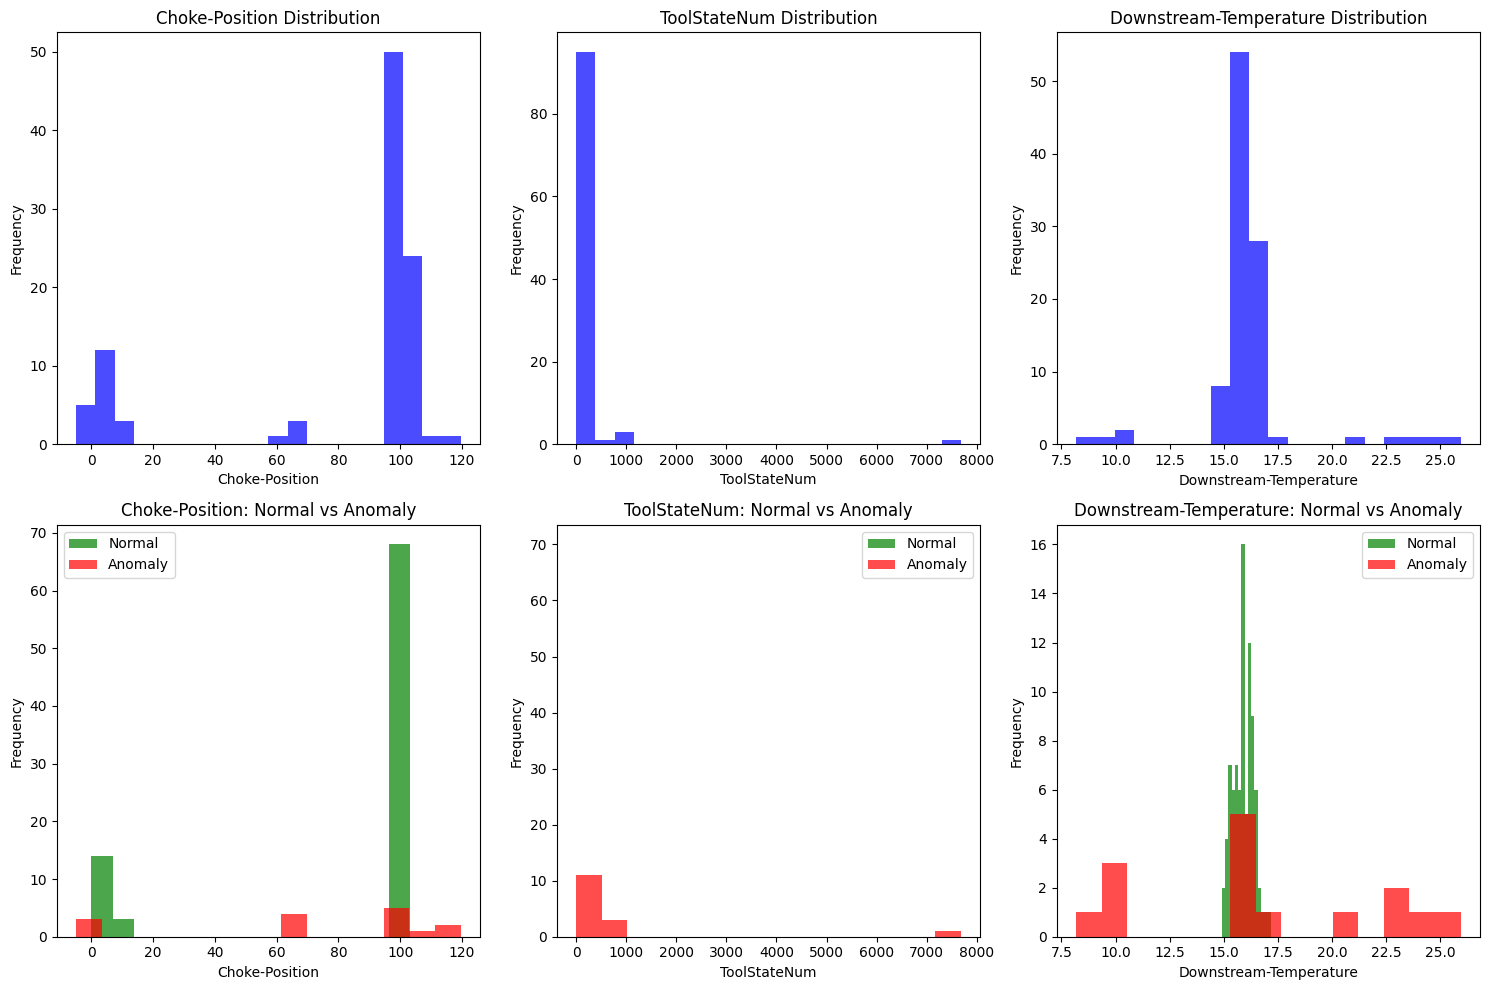


Example anomalies in the dataset:


,Choke-Position,ToolStateNum,Downstream-Temperature,is_anomaly
9,99.789763,10,8.181216,1
12,100.168327,10,10.463405,1
28,-4.898597,2,15.654135,1
42,67.109212,1024,20.876651,1
46,62.995474,1024,23.079250,1
55,98.369458,2,25.941570,1
61,66.719602,512,23.442500,1
71,-1.946542,2,15.411517,1
72,-2.496560,10,16.756110,1
78,99.785611,2,9.755886,1


In [5]:
# Visualize the synthetic dataset
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Distribution plots
for i, col in enumerate(IF_CHOKE_FEATS):
    # Overall distribution
    axes[0, i].hist(synthetic_df[col], bins=20, alpha=0.7, color='blue', label='All')
    axes[0, i].set_title(f'{col} Distribution')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Frequency')
    
    # Normal vs Anomaly
    axes[1, i].hist(normal_data[col], bins=15, alpha=0.7, color='green', label='Normal')
    axes[1, i].hist(anomaly_data[col], bins=15, alpha=0.7, color='red', label='Anomaly')
    axes[1, i].set_title(f'{col}: Normal vs Anomaly')
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

# Show some example anomalies
print("\nExample anomalies in the dataset:")
display(anomaly_data.head(10))

In [6]:
# Save the expanded synthetic dataset
output_path = Path('training_data/synth_choke_position_100pts.parquet')
output_path.parent.mkdir(parents=True, exist_ok=True)

synthetic_df.to_parquet(output_path, index=False)
print(f"✅ Saved expanded synthetic dataset to: {output_path}")
print(f"   Size: {len(synthetic_df)} points")
print(f"   Normal: {len(normal_data)} points ({len(normal_data)/len(synthetic_df)*100:.1f}%)")
print(f"   Anomalies: {len(anomaly_data)} points ({len(anomaly_data)/len(synthetic_df)*100:.1f}%)")

# Also keep the original small dataset
print(f"\n📋 Dataset summary:")
print(f"   Original (10 pts): training_data/synth_choke_position.parquet")
print(f"   Expanded (100 pts): {output_path}")
print(f"\n🎯 Ready to test with the expanded dataset!")

✅ Saved expanded synthetic dataset to: training_data/synth_choke_position_100pts.parquet
   Size: 100 points
   Normal: 85 points (85.0%)
   Anomalies: 15 points (15.0%)

📋 Dataset summary:
   Original (10 pts): training_data/synth_choke_position.parquet
   Expanded (100 pts): training_data/synth_choke_position_100pts.parquet

🎯 Ready to test with the expanded dataset!
